In [ ]:
pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 22.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
!pip install xgboost==2.0.3

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from google.colab import drive
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report
import seaborn as sns
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Angle_Open_landmarks_norm.csv')

In [ ]:
data
#data = data[['Class', 'Landmark_2_x','Landmark_1_y','Landmark_3_y','Landmark_2_z','Landmark_3_z','Landmark_4_z']]
#data

,Class,Landmark_1_x,Landmark_2_x,Landmark_3_x,Landmark_4_x,Landmark_1_y,Landmark_2_y,Landmark_3_y,Landmark_4_y,Landmark_1_z,Landmark_2_z,Landmark_3_z,Landmark_4_z
0,0,0.0,0.487500,1.237500,0.237500,0.0,-0.783333,-0.116667,0.316667,0.0,-0.257028,-0.702887,-1.092902
1,0,0.0,0.474359,1.128205,0.128205,0.0,-0.649573,-0.017094,0.410256,0.0,-0.344103,-1.087938,-1.396106
2,0,0.0,0.385714,1.171429,0.171429,0.0,-0.514286,-0.038095,0.457143,0.0,-0.295804,-1.073725,-1.519810
3,0,0.0,0.350649,1.051948,0.051948,0.0,-0.346320,0.069264,0.467532,0.0,-0.241141,-0.970282,-1.391957
4,0,0.0,0.402985,1.208955,0.208955,0.0,-0.457711,0.000000,0.457711,0.0,-0.289913,-0.877638,-1.285838
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,1,0.0,0.528090,1.134831,0.134831,0.0,-0.284644,0.134831,0.239700,0.0,-0.154507,-0.602631,-0.866941
2396,1,0.0,0.544444,1.100000,0.100000,0.0,-0.266667,0.177778,0.266667,0.0,-0.159287,-0.665729,-0.913804
2397,1,0.0,0.533333,1.100000,0.100000,0.0,-0.251852,0.237037,0.340741,0.0,-0.169232,-0.684946,-0.902210
2398,1,0.0,0.511111,1.111111,0.111111,0.0,-0.281481,0.207407,0.311111,0.0,-0.165618,-0.652337,-0.899921


In [ ]:
X = data.drop('Class', axis=1)
Y = data['Class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

In [ ]:
validation_data = (X_val, y_val)
def create_model(batch_size=32, learning_rate=0.01, activation='relu', neurons=32, validation_data=None):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    for i in range(3):
        model.add(Dense(neurons, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=1000, batch_size=batch_size, validation_data=validation_data, callbacks=[early_stopping], verbose=0)
    best_epoch = early_stopping.stopped_epoch + 1
    return model

In [ ]:
param_grid = {
    'model__neurons' : [64, 96, 128],
    'model__batch_size': [32, 64, 128],
    'model__learning_rate': [0.01, 0.001, 0.0001]
}

In [ ]:
model = KerasClassifier(build_fn=create_model, verbose=0)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
grid_neural = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=2)
grid_neural_result = grid_neural.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.01, model__neurons=64; total time=   6.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.01, model__neurons=64; total time=   5.1s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.01, model__neurons=64; total time=   5.9s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.01, model__neurons=64; total time=   5.7s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.01, model__neurons=64; total time=   6.7s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.01, model__neurons=96; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.01, model__neurons=96; total time=   7.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.01, model__neurons=96; total time=   5.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.01, model__neurons=96; total time=   5.1s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.01, model__neurons=96; total time=   5.2s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.01, model__neurons=128; total time=   5.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.01, model__neurons=128; total time=   5.9s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.01, model__neurons=128; total time=   4.7s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.01, model__neurons=128; total time=   5.7s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.01, model__neurons=128; total time=   7.7s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.001, model__neurons=64; total time=   8.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.001, model__neurons=64; total time=  34.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.001, model__neurons=64; total time=  49.1s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.001, model__neurons=64; total time=   7.8s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.001, model__neurons=64; total time=  11.8s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.001, model__neurons=96; total time=   5.9s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.001, model__neurons=96; total time=  10.8s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.001, model__neurons=96; total time=   8.9s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.001, model__neurons=96; total time=   7.2s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.001, model__neurons=96; total time=   9.7s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.001, model__neurons=128; total time=  53.7s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.001, model__neurons=128; total time=   6.2s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.001, model__neurons=128; total time=  10.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.001, model__neurons=128; total time=   6.8s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.001, model__neurons=128; total time=   5.9s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.0001, model__neurons=64; total time=  49.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.0001, model__neurons=64; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.0001, model__neurons=64; total time=  16.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.0001, model__neurons=64; total time=  29.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.0001, model__neurons=64; total time=  28.2s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.0001, model__neurons=96; total time=  29.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.0001, model__neurons=96; total time=  17.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.0001, model__neurons=96; total time=  20.9s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.0001, model__neurons=96; total time=  44.1s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.0001, model__neurons=96; total time=  41.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.0001, model__neurons=128; total time=  14.7s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.0001, model__neurons=128; total time=  15.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.0001, model__neurons=128; total time=  11.8s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.0001, model__neurons=128; total time=  27.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=32, model__learning_rate=0.0001, model__neurons=128; total time=  24.8s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.01, model__neurons=64; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.01, model__neurons=64; total time=   6.1s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.01, model__neurons=64; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.01, model__neurons=64; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.01, model__neurons=64; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.01, model__neurons=96; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.01, model__neurons=96; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.01, model__neurons=96; total time=   5.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.01, model__neurons=96; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.01, model__neurons=96; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.01, model__neurons=128; total time=   5.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.01, model__neurons=128; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.01, model__neurons=128; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.01, model__neurons=128; total time=   5.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.01, model__neurons=128; total time=   6.1s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.001, model__neurons=64; total time=  10.2s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.001, model__neurons=64; total time=  10.9s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.001, model__neurons=64; total time=   5.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.001, model__neurons=64; total time=   4.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.001, model__neurons=64; total time=   5.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.001, model__neurons=96; total time=   6.2s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.001, model__neurons=96; total time=   6.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.001, model__neurons=96; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.001, model__neurons=96; total time=   5.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.001, model__neurons=96; total time=   8.1s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.001, model__neurons=128; total time=   4.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.001, model__neurons=128; total time=   6.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.001, model__neurons=128; total time=   4.6s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.001, model__neurons=128; total time=   5.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.001, model__neurons=128; total time=   6.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.0001, model__neurons=64; total time=  30.7s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.0001, model__neurons=64; total time=  20.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.0001, model__neurons=64; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.0001, model__neurons=64; total time=  45.7s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.0001, model__neurons=64; total time=  22.1s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.0001, model__neurons=96; total time=  22.8s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.0001, model__neurons=96; total time=  46.6s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.0001, model__neurons=96; total time=  17.7s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.0001, model__neurons=96; total time=  18.7s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.0001, model__neurons=96; total time=  17.8s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.0001, model__neurons=128; total time=  20.6s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.0001, model__neurons=128; total time=  19.8s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.0001, model__neurons=128; total time=  14.1s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.0001, model__neurons=128; total time=  22.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=64, model__learning_rate=0.0001, model__neurons=128; total time=  38.1s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.01, model__neurons=64; total time=   5.1s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.01, model__neurons=64; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.01, model__neurons=64; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.01, model__neurons=64; total time=   7.1s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.01, model__neurons=64; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.01, model__neurons=96; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.01, model__neurons=96; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.01, model__neurons=96; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.01, model__neurons=96; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.01, model__neurons=96; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.01, model__neurons=128; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.01, model__neurons=128; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.01, model__neurons=128; total time=   3.8s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.01, model__neurons=128; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.01, model__neurons=128; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.001, model__neurons=64; total time=   6.1s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.001, model__neurons=64; total time=   5.6s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.001, model__neurons=64; total time=   4.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.001, model__neurons=64; total time=   7.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.001, model__neurons=64; total time=   6.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.001, model__neurons=96; total time=   7.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.001, model__neurons=96; total time=  40.7s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.001, model__neurons=96; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.001, model__neurons=96; total time=   5.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.001, model__neurons=96; total time=   8.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.001, model__neurons=128; total time=   5.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.001, model__neurons=128; total time=   6.8s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.001, model__neurons=128; total time=   5.1s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.001, model__neurons=128; total time=   5.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.001, model__neurons=128; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.0001, model__neurons=64; total time=  18.2s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.0001, model__neurons=64; total time=  24.8s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.0001, model__neurons=64; total time=  28.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.0001, model__neurons=64; total time=  21.1s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.0001, model__neurons=64; total time=  18.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.0001, model__neurons=96; total time=  16.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.0001, model__neurons=96; total time=  20.6s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.0001, model__neurons=96; total time=  14.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.0001, model__neurons=96; total time=  17.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.0001, model__neurons=96; total time=   8.9s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.0001, model__neurons=128; total time=  18.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.0001, model__neurons=128; total time=  12.6s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.0001, model__neurons=128; total time=  24.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.0001, model__neurons=128; total time=  16.8s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END model__batch_size=128, model__learning_rate=0.0001, model__neurons=128; total time=  25.7s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
df_cv_results = pd.DataFrame(grid_neural_result.cv_results_)
df_cv_results = df_cv_results[['rank_test_score','mean_test_score',
                               'param_model__learning_rate', 'param_model__batch_size', 'param_model__neurons']]
df_cv_results.sort_values(by='rank_test_score', inplace=True)
df_cv_results

,rank_test_score,mean_test_score,param_model__learning_rate,param_model__batch_size,param_model__neurons
6,1,0.998437,0.0001,32,64
15,2,0.997917,0.0001,64,64
7,3,0.997396,0.0001,32,96
26,4,0.996875,0.0001,128,128
16,4,0.996875,0.0001,64,96
5,4,0.996875,0.001,32,128
24,7,0.996354,0.0001,128,64
17,8,0.996354,0.0001,64,128
4,9,0.995833,0.001,32,96
8,10,0.995313,0.0001,32,128


Text(0.5, 1.0, 'Performance wrt # of batch size and neurons')

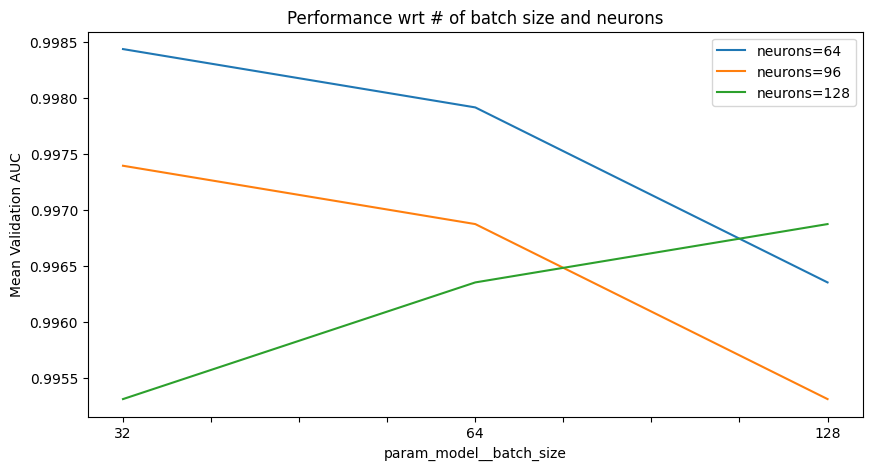

In [ ]:
df_cv_results.sort_values(by='param_model__batch_size', inplace=True)
lr_d64 = df_cv_results.loc[(df_cv_results['param_model__learning_rate']==0.0001) & (df_cv_results['param_model__neurons']==64),:]
lr_d96 = df_cv_results.loc[(df_cv_results['param_model__learning_rate']==0.0001) & (df_cv_results['param_model__neurons']==96),:]
lr_d128 = df_cv_results.loc[(df_cv_results['param_model__learning_rate']==0.0001) & (df_cv_results['param_model__neurons']==128),:]

fig, ax = plt.subplots(figsize=(10,5))
lr_d64.plot(x='param_model__batch_size', y='mean_test_score', label='neurons=64', ax=ax)
lr_d96.plot(x='param_model__batch_size', y='mean_test_score', label='neurons=96', ax=ax)
lr_d128.plot(x='param_model__batch_size', y='mean_test_score', label='neurons=128', ax=ax)
plt.ylabel('Mean Validation AUC')
plt.title('Performance wrt # of batch size and neurons')

Text(0.5, 1.0, 'Performance wrt learning rate')

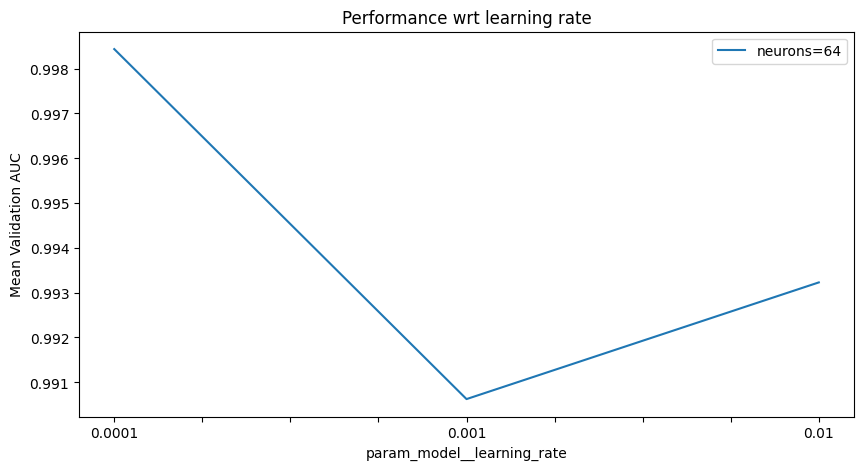

In [ ]:
df_cv_results.sort_values(by='param_model__learning_rate', inplace=True)
lr_t3k_d128 = df_cv_results.loc[(df_cv_results['param_model__batch_size']==32) & (df_cv_results['param_model__neurons']==64),:]
fig, ax = plt.subplots(figsize=(10,5))
lr_t3k_d128.plot(x='param_model__learning_rate', y='mean_test_score', label='neurons=64', ax=ax)
plt.ylabel('Mean Validation AUC')
plt.title('Performance wrt learning rate')

In [ ]:
model_neural_fin = tf.keras.models.Sequential()
model_neural_fin.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model_neural_fin.add(tf.keras.layers.Dense(64, activation='relu'))
model_neural_fin.add(tf.keras.layers.Dense(64, activation='relu'))
model_neural_fin.add(tf.keras.layers.Dense(64, activation='relu'))
model_neural_fin.add(tf.keras.layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_neural_fin.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model_neural_fin.fit(X_train, y_train, epochs=1000, batch_size=32, callbacks=[early_stopping], validation_data=(X_val, y_val))
test_loss, test_accuracy = model_neural_fin.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

Epoch 1/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7614 - loss: 0.6838 - val_accuracy: 0.8255 - val_loss: 0.6617
Epoch 2/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8009 - loss: 0.6564 - val_accuracy: 0.8776 - val_loss: 0.6298
Epoch 3/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8881 - loss: 0.6201 - val_accuracy: 0.9036 - val_loss: 0.5821
Epoch 4/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9056 - loss: 0.5645 - val_accuracy: 0.8828 - val_loss: 0.5073
Epoch 5/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9066 - loss: 0.4871 - val_accuracy: 0.8880 - val_loss: 0.4255
Epoch 6/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9007 - loss: 0.4053 - val_accuracy: 0.8854 - val_loss: 0.3539
Epoch 7/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8863 - loss: 0.3464 - val_accuracy: 0.8828 - val_loss: 0.2994
Epoch 8/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9228 - loss: 0.2620 - val_accuracy: 0.

In [ ]:
y_pred = model_neural_fin.predict(X_test)
y_pred_classes = np.round(y_pred).astype(int)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_classes)
auc_score = auc(fpr, tpr)
conf_matrix = confusion_matrix(y_test, y_pred_classes)

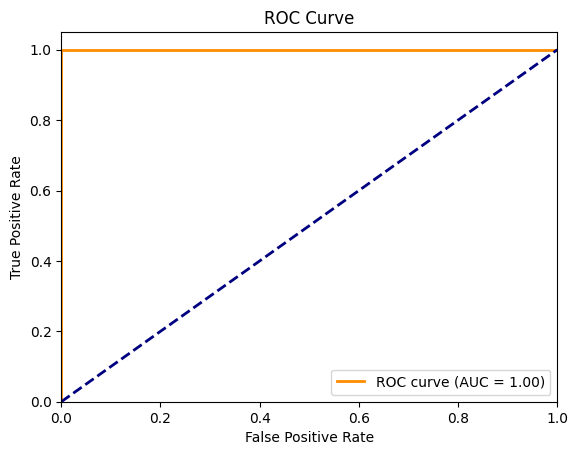

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

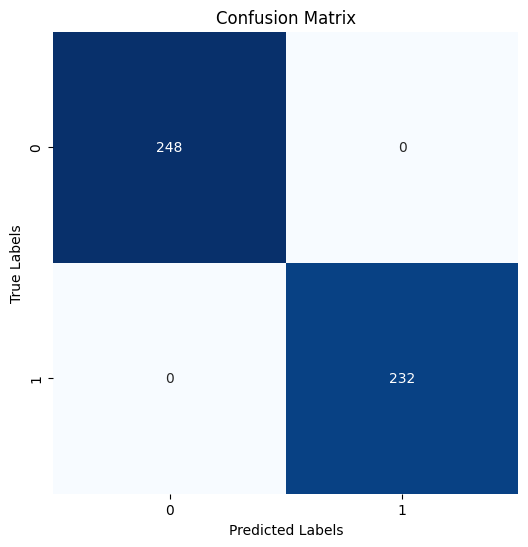

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       248
           1       1.00      1.00      1.00       232

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test, y_pred_classes))

XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

In [ ]:
def my_roc_auc_score(model, X, y):
  xg_pred = model.predict(X)
  fpr, tpr, thresholds = roc_curve(y, xg_pred)
  xg_score = auc(fpr, tpr)
  return xg_score

In [ ]:
param_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'n_estimators': [100, 600, 1100, 1600, 2100],
    'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]
}

In [ ]:
boost_model = GridSearchCV(estimator=XGBClassifier(subsample=0.5,colsample_bytree=0.25,eval_metric='auc',use_label_encoder='False'),param_grid=param_grid,cv=5,scoring=my_roc_auc_score,return_train_score=True,verbose=4)
boost_model.fit(X_train_val,y_train_val)


Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=100;, score=(train=0.991, test=0.984) total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=100;, score=(train=0.990, test=0.979) total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=100;, score=(train=0.989, test=0.987) total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=2, n_estimators=100;, score=(train=0.991, test=0.984) total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=2, n_estimators=100;, score=(train=0.990, test=0.987) total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=2, n_estimators=600;, score=(train=1.000, test=0.984) total time=   0.2s
[CV 2/5] END learning_rate=0.1, max_depth=2, n_estimators=600;, score=(train=1.000, test=0.982) total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=2, n_estimators=600;, score=(train=1.000, test=0.995) total time=   0.2s
[CV 4/5] END lear

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.25, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9, 1.1],
                         'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [100, 600, 1100, 1600, 2100]},
             return_train_score=True,
             scoring=<function my_roc_auc_score at 0x7f029dd4f010>, verbose=4)

In [ ]:
df_cv_results = pd.DataFrame(boost_model.cv_results_)
df_cv_results = df_cv_results[['rank_test_score','mean_test_score','mean_train_score',
                               'param_learning_rate', 'param_max_depth', 'param_n_estimators']]
df_cv_results.sort_values(by='rank_test_score', inplace=True)
df_cv_results

,rank_test_score,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_n_estimators
18,1,0.991653,1.000000,0.1,8,1600
17,1,0.991653,1.000000,0.1,8,1100
9,3,0.991137,1.000000,0.1,4,2100
22,4,0.991126,1.000000,0.1,10,1100
19,5,0.991126,1.000000,0.1,8,2100
...,...,...,...,...,...,...
87,146,0.984849,1.000000,0.7,6,1100
137,147,0.984843,1.000000,1.1,6,1100
138,147,0.984843,1.000000,1.1,6,1600
0,149,0.984341,0.990215,0.1,2,100


Text(0.5, 1.0, 'Performance wrt # of Trees and Depth')

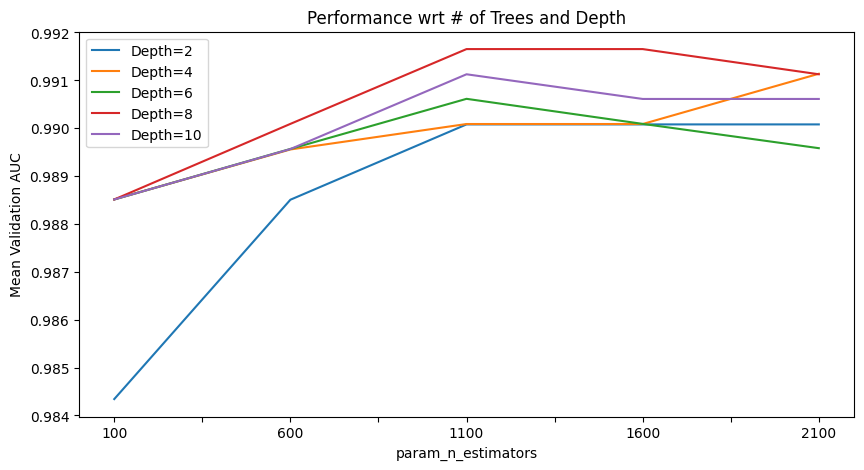

In [ ]:
df_cv_results.sort_values(by='param_n_estimators', inplace=True)
lr_d2 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.1) & (df_cv_results['param_max_depth']==2),:]
lr_d4 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.1) & (df_cv_results['param_max_depth']==4),:]
lr_d6 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.1) & (df_cv_results['param_max_depth']==6),:]
lr_d8 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.1) & (df_cv_results['param_max_depth']==8),:]
lr_d10 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.1) & (df_cv_results['param_max_depth']==10),:]
fig, ax = plt.subplots(figsize=(10,5))
lr_d2.plot(x='param_n_estimators', y='mean_test_score', label='Depth=2', ax=ax)
lr_d4.plot(x='param_n_estimators', y='mean_test_score', label='Depth=4', ax=ax)
lr_d6.plot(x='param_n_estimators', y='mean_test_score', label='Depth=6', ax=ax)
lr_d8.plot(x='param_n_estimators', y='mean_test_score', label='Depth=8', ax=ax)
lr_d10.plot(x='param_n_estimators', y='mean_test_score', label='Depth=10', ax=ax)
plt.ylabel('Mean Validation AUC')
plt.title('Performance wrt # of Trees and Depth')

Text(0.5, 1.0, 'Performance wrt learning rate')

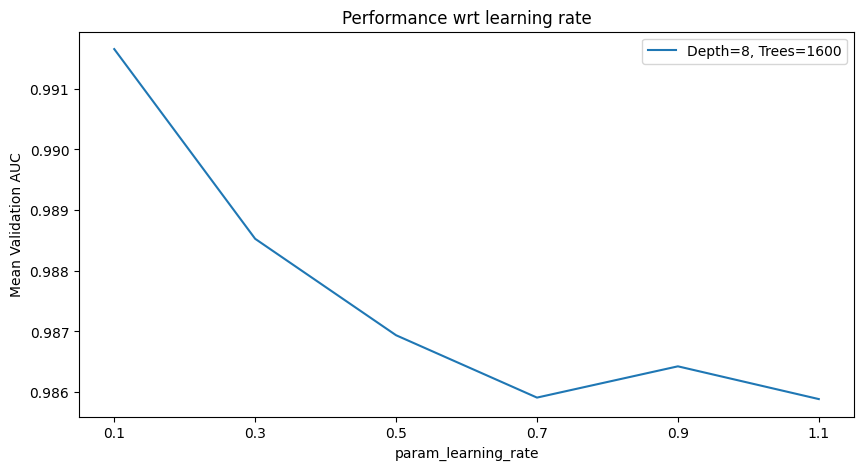

In [ ]:
df_cv_results.sort_values(by='param_learning_rate', inplace=True)
lr_t3k_d2 = df_cv_results.loc[(df_cv_results['param_n_estimators']==1600) & (df_cv_results['param_max_depth']==8),:]
fig, ax = plt.subplots(figsize=(10,5))
lr_t3k_d2.plot(x='param_learning_rate', y='mean_test_score', label='Depth=8, Trees=1600', ax=ax)
plt.ylabel('Mean Validation AUC')
plt.title('Performance wrt learning rate')

In [ ]:
model_xgboost_fin = XGBClassifier(learning_rate=0.1,max_depth=8,n_estimators=1600,subsample=0.5,colsample_bytree=0.25,eval_metric='auc',verbosity=1,use_label_encoder=False)
eval_set = [(X_val, y_val)]
model_xgboost_fin.fit(X_train,y_train,early_stopping_rounds=20,eval_set=eval_set,verbose=True)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.99152
[1]	validation_0-auc:0.98462
[2]	validation_0-auc:0.99228
[3]	validation_0-auc:0.99839
[4]	validation_0-auc:0.99875
[5]	validation_0-auc:0.99918
[6]	validation_0-auc:0.99905
[7]	validation_0-auc:0.99910
[8]	validation_0-auc:0.99905
[9]	validation_0-auc:0.99883
[10]	validation_0-auc:0.99891
[11]	validation_0-auc:0.99880
[12]	validation_0-auc:0.99861
[13]	validation_0-auc:0.99858
[14]	validation_0-auc:0.99855
[15]	validation_0-auc:0.99839
[16]	validation_0-auc:0.99836
[17]	validation_0-auc:0.99817
[18]	validation_0-auc:0.99836
[19]	validation_0-auc:0.99845
[20]	validation_0-auc:0.99877
[21]	validation_0-auc:0.99875
[22]	validation_0-auc:0.99883
[23]	validation_0-auc:0.99891
[24]	validation_0-auc:0.99896
[25]	validation_0-auc:0.99891


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.25, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1600, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_fin_pred = model_xgboost_fin.predict(X_test)
y_fin_pred = np.round(y_fin_pred).astype(int)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,y_fin_pred)
auc_xg_score = auc(fpr, tpr)

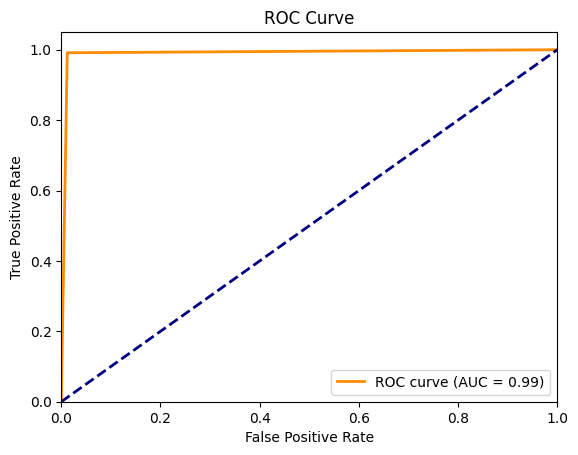

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_xg_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
conf_xgb_matrix = confusion_matrix(y_test,y_fin_pred)

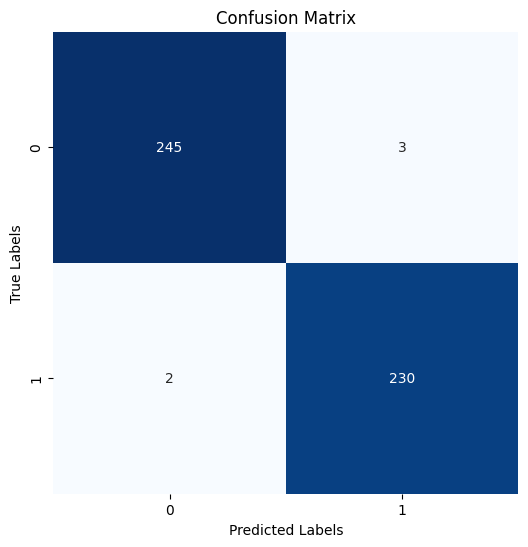

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       248
           1       0.99      0.99      0.99       232

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480



In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_xgb_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test,y_fin_pred))

Random Forest

In [ ]:
!pip install tpot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11938 sha256=1fe2d4f7feb9a8a205099d33cb33362656c3ad57ff71731f311d35a2bf874d5b
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from tpot import TPOTClassifier

In [ ]:
params_grid = {
    'n_estimators': [100,200,300,400,500,600],
    'criterion': ['gini', 'entropy'],
    'max_depth': [8, 10, 12, 14, 16],
    'min_samples_split': [0.001,0.006,0.011,0.016,0.021,0.026],
    'min_samples_leaf': [0.001,0.006,0.011,0.016,0.021,0.026],
    'max_features': ['sqrt', 'log2']
}

In [ ]:
tpot_classifier = TPOTClassifier(generations= 5, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict={'sklearn.ensemble.RandomForestClassifier': params_grid},
                                 cv = 5, scoring = 'accuracy')
tpot_classifier.fit(X_train_val,y_train_val)

Optimization Progress:   0%|          | 0/84 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9895833333333333

Generation 2 - Current best internal CV score: 0.9895833333333333

Generation 3 - Current best internal CV score: 0.990625

Generation 4 - Current best internal CV score: 0.990625

Generation 5 - Current best internal CV score: 0.9916666666666668

Best pipeline: RandomForestClassifier(input_matrix, criterion=entropy, max_depth=8, max_features=log2, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=500)


TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'criterion': ['gini',
                                                                                      'entropy'],
                                                                        'max_depth': [8,
                                                                                      10,
                                                                                      12,
                                                                                      14,
                                                                                      16],
                                                                        'max_features': ['sqrt',
                                                                                         'log2'],
                                                                        'min_samples_leaf': [0.001,
                                                                                             0.006,
                                                                                             0.011,
                                                                                             0.016,
                                                                                             0.021,
                                                                                             0.026],
                                                                        'min_samples_split': [0.001,
                                                                                              0.006,
                                                                                              0.011,
                                                                                              0.016,
                                                                                              0.021,
                                                                                              0.026],
                                                                        'n_estimators': [100,
                                                                                         200,
                                                                                         300,
                                                                                         400,
                                                                                         500,
                                                                                         600]}},
               early_stop=12, generations=5, offspring_size=12,
               population_size=24, scoring='accuracy', verbosity=2)

In [ ]:
params_grid = {
    'n_estimators': [100,200,300,400,500,600],
    'criterion': ['entropy'],
    'max_depth': [10,12,14,16],
    'min_samples_split': [0.001, 0.006, 0.011],
    'min_samples_leaf': [0.001, 0.006, 0.011],
    'max_features': ['log2']
}

In [ ]:
model_GridRF = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'),param_grid=params_grid,cv=5,scoring=my_roc_auc_score,return_train_score=True,verbose=2)
model_GridRF.fit(X_train_val,y_train_val)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100; total time=   1.4s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100; total time=   1.5s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100; total time=   0.6s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=10, max_features

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'criterion': ['entropy'],
                         'max_depth': [10, 12, 14, 16],
                         'max_features': ['log2'],
                         'min_samples_leaf': [0.001, 0.006, 0.011],
                         'min_samples_split': [0.001, 0.006, 0.011],
                         'n_estimators': [100, 200, 300, 400, 500, 600]},
             return_train_score=True,
             scoring=<function my_roc_auc_score at 0x7f029dd4f010>, verbose=2)

In [ ]:
df_cv_results = pd.DataFrame(model_GridRF.cv_results_)
df_cv_results = df_cv_results[['rank_test_score','mean_test_score','mean_train_score',
                           'param_n_estimators', 'param_min_samples_split','param_min_samples_leaf',
                           'param_max_features', 'param_max_depth','param_criterion']]
df_cv_results.sort_values('rank_test_score', inplace=True)
df_cv_results[:20]

,rank_test_score,mean_test_score,mean_train_score,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion
2,1,0.992187,0.999610,300,0.001,0.001,log2,10,entropy
4,2,0.992184,0.999479,500,0.001,0.001,log2,10,entropy
56,3,0.991672,0.999219,300,0.001,0.001,log2,12,entropy
112,3,0.991672,0.999608,500,0.001,0.001,log2,14,entropy
167,3,0.991672,0.999348,600,0.001,0.001,log2,16,entropy
166,6,0.991661,0.999608,500,0.001,0.001,log2,16,entropy
171,6,0.991661,0.996881,400,0.006,0.001,log2,16,entropy
113,6,0.991661,0.999219,600,0.001,0.001,log2,14,entropy
109,9,0.991650,0.999608,200,0.001,0.001,log2,14,entropy
1,10,0.991153,0.999089,200,0.001,0.001,log2,10,entropy


In [ ]:
df_cv_results.sort_values(by='param_n_estimators', inplace=True)
lr_d10 = df_cv_results.loc[(df_cv_results['param_min_samples_split']==0.001) & (df_cv_results['param_min_samples_leaf']==0.001) & (df_cv_results['param_max_features']=='log2') & (df_cv_results['param_criterion']=='entropy') & (df_cv_results['param_max_depth']==10),:]
lr_d12 = df_cv_results.loc[(df_cv_results['param_min_samples_split']==0.001) & (df_cv_results['param_min_samples_leaf']==0.001) & (df_cv_results['param_max_features']=='log2') & (df_cv_results['param_criterion']=='entropy') & (df_cv_results['param_max_depth']==12),:]
lr_d14 = df_cv_results.loc[(df_cv_results['param_min_samples_split']==0.001) & (df_cv_results['param_min_samples_leaf']==0.001) & (df_cv_results['param_max_features']=='log2') & (df_cv_results['param_criterion']=='entropy') & (df_cv_results['param_max_depth']==14),:]
lr_d16 = df_cv_results.loc[(df_cv_results['param_min_samples_split']==0.001) & (df_cv_results['param_min_samples_leaf']==0.001) & (df_cv_results['param_max_features']=='log2') & (df_cv_results['param_criterion']=='entropy') & (df_cv_results['param_max_depth']==16),:]

Text(0.5, 1.0, 'Performance wrt # of Trees and Depth')

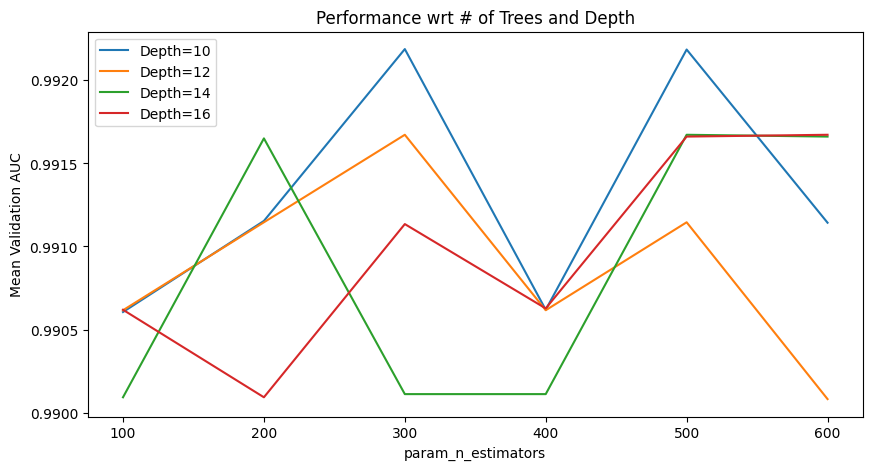

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
lr_d10.plot(x='param_n_estimators', y='mean_test_score', label='Depth=10', ax=ax)
lr_d12.plot(x='param_n_estimators', y='mean_test_score', label='Depth=12', ax=ax)
lr_d14.plot(x='param_n_estimators', y='mean_test_score', label='Depth=14', ax=ax)
lr_d16.plot(x='param_n_estimators', y='mean_test_score', label='Depth=16', ax=ax)
plt.ylabel('Mean Validation AUC')
plt.title('Performance wrt # of Trees and Depth')

In [ ]:
df_cv_results.sort_values(by='param_min_samples_split', inplace=True)
lr_d01 = df_cv_results.loc[(df_cv_results['param_min_samples_leaf']==0.001) & (df_cv_results['param_n_estimators']==300) & (df_cv_results['param_max_features']=='log2') & (df_cv_results['param_criterion']=='entropy') & (df_cv_results['param_max_depth']==10),:]
lr_d06 = df_cv_results.loc[(df_cv_results['param_min_samples_leaf']==0.006) & (df_cv_results['param_n_estimators']==300) & (df_cv_results['param_max_features']=='log2') & (df_cv_results['param_criterion']=='entropy') & (df_cv_results['param_max_depth']==10),:]
lr_d11 = df_cv_results.loc[(df_cv_results['param_min_samples_leaf']==0.011) & (df_cv_results['param_n_estimators']==300) & (df_cv_results['param_max_features']=='log2') & (df_cv_results['param_criterion']=='entropy') & (df_cv_results['param_max_depth']==10),:]

Text(0.5, 1.0, 'Performance with difference split and leaf')

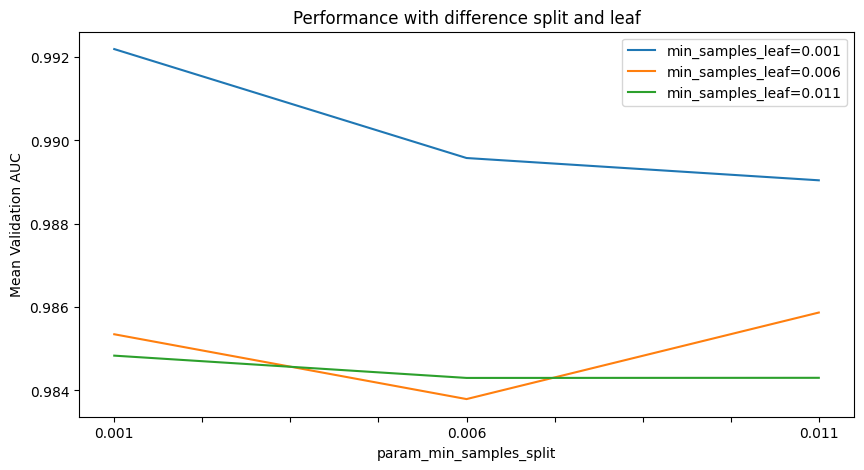

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
lr_d01.plot(x='param_min_samples_split', y='mean_test_score', label='min_samples_leaf=0.001', ax=ax)
lr_d06.plot(x='param_min_samples_split', y='mean_test_score', label='min_samples_leaf=0.006', ax=ax)
lr_d11.plot(x='param_min_samples_split', y='mean_test_score', label='min_samples_leaf=0.011', ax=ax)
plt.ylabel('Mean Validation AUC')
plt.title('Performance with difference split and leaf')

In [ ]:
model_RF_fin = RandomForestClassifier(max_depth=10,n_estimators=300,min_samples_split=0.001,min_samples_leaf=0.001,max_features='log2',criterion='entropy')
model_RF_fin.fit(X_train_val, y_train_val)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       min_samples_leaf=0.001, min_samples_split=0.001,
                       n_estimators=300)

In [ ]:
y_fin_pred = model_RF_fin.predict(X_test)
y_fin_pred = np.round(y_fin_pred).astype(int)

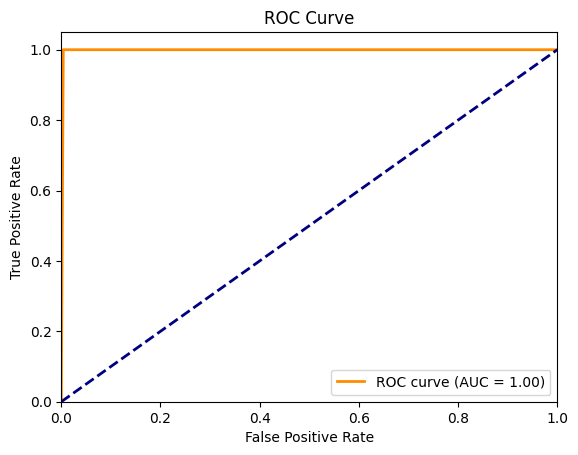

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,y_fin_pred)
auc_xg_score = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_xg_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

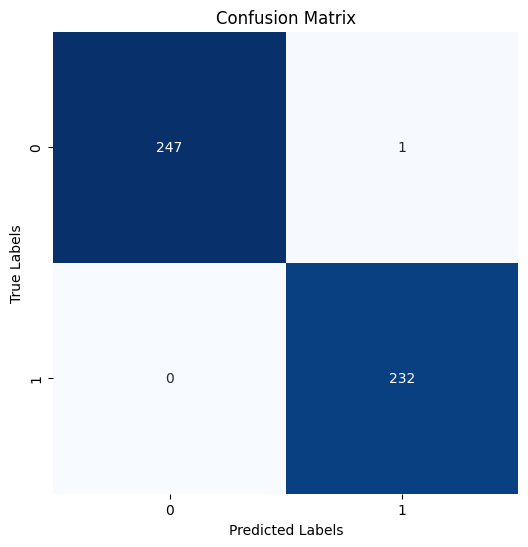

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       248
           1       1.00      1.00      1.00       232

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



In [ ]:
conf_xgb_matrix = confusion_matrix(y_test,y_fin_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_xgb_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test,y_fin_pred))

In [ ]:
model_neural_fin = tf.keras.models.Sequential()
model_neural_fin.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model_neural_fin.add(tf.keras.layers.Dense(64, activation='relu'))
model_neural_fin.add(tf.keras.layers.Dense(64, activation='relu'))
model_neural_fin.add(tf.keras.layers.Dense(64, activation='relu'))
model_neural_fin.add(tf.keras.layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_neural_fin.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model_neural_fin.fit(X_train, y_train, epochs=1000, batch_size=64, callbacks=[early_stopping], validation_data=(X_val, y_val))
test_loss, test_accuracy = model_neural_fin.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

Epoch 1/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4674 - loss: 0.6898 - val_accuracy: 0.5365 - val_loss: 0.6613
Epoch 2/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4891 - loss: 0.6676 - val_accuracy: 0.5365 - val_loss: 0.6430
Epoch 3/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4968 - loss: 0.6490 - val_accuracy: 0.6094 - val_loss: 0.6241
Epoch 4/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5943 - loss: 0.6301 - val_accuracy: 0.6797 - val_loss: 0.6026
Epoch 5/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6686 - loss: 0.6063 - val_accuracy: 0.8073 - val_loss: 0.5768
Epoch 6/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7981 - loss: 0.5796 - val_accuracy: 0.8490 - val_loss: 0.5481
Epoch 7/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8653 - loss: 0.5531 - val_accuracy: 0.8672 - val_loss: 0.5166
Epoch 8/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8637 - loss: 0.5193 - val_accuracy:

In [ ]:
X_fin_test = pd.read_csv('/content/drive/MyDrive/Angle_Open_test_norm.csv')
y_fin_test = pd.read_csv('/content/drive/MyDrive/Angle_Open_test_class.csv')

In [ ]:
y_fin_pred_test = model_neural_fin.predict(X_fin_test)
y_fin_pred_test = np.round(y_fin_pred_test).astype(int)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
y_fin_pred_test[270:360]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

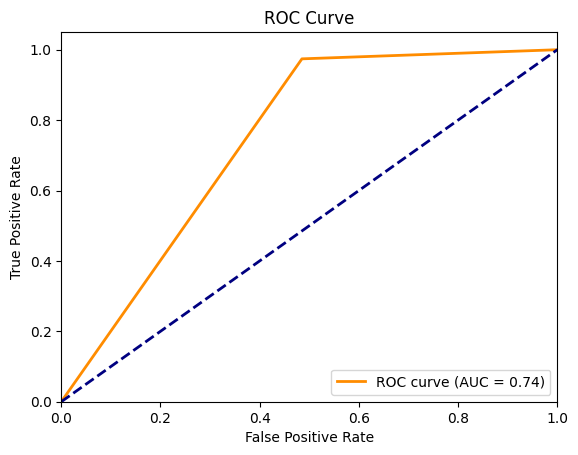

In [ ]:
fpr, tpr, thresholds = roc_curve(y_fin_test,y_fin_pred_test)
auc_xg_score = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_xg_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

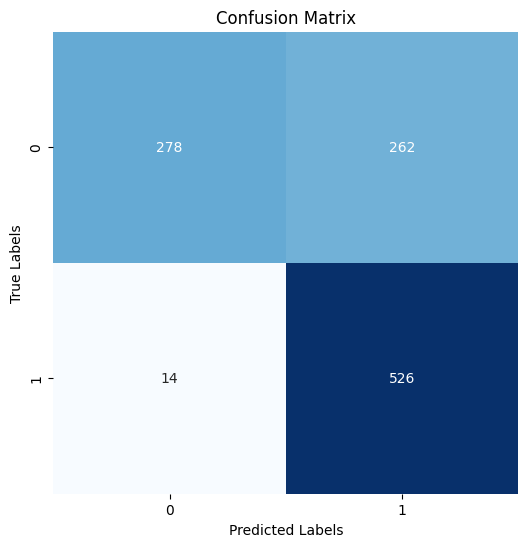

              precision    recall  f1-score   support

           0       0.95      0.51      0.67       540
           1       0.67      0.97      0.79       540

    accuracy                           0.74      1080
   macro avg       0.81      0.74      0.73      1080
weighted avg       0.81      0.74      0.73      1080



In [ ]:
conf_xgb_matrix = confusion_matrix(y_fin_test,y_fin_pred_test)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_xgb_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_fin_test,y_fin_pred_test))

In [ ]:
model_RF_fin = RandomForestClassifier(max_depth=10,n_estimators=300,min_samples_split=0.001,min_samples_leaf=0.001,max_features='log2',criterion='entropy')
model_RF_fin.fit(X, Y)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       min_samples_leaf=0.001, min_samples_split=0.001,
                       n_estimators=300)

In [ ]:
y_fin_pred_test = model_RF_fin.predict(X_fin_test)
y_fin_pred_test = np.round(y_fin_pred_test).astype(int)

In [ ]:
y_fin_pred_test[360:450]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0])

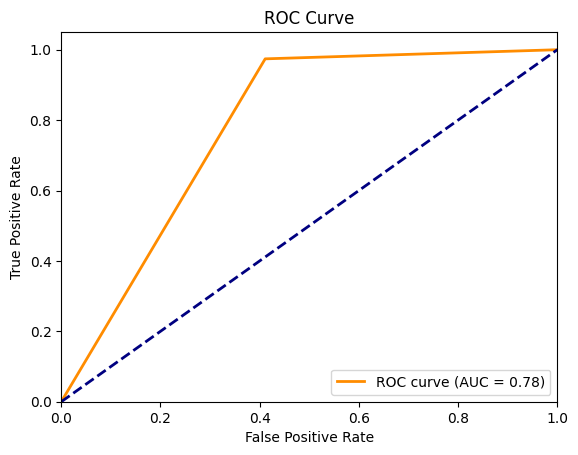

In [ ]:
fpr, tpr, thresholds = roc_curve(y_fin_test,y_fin_pred_test)
auc_xg_score = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_xg_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

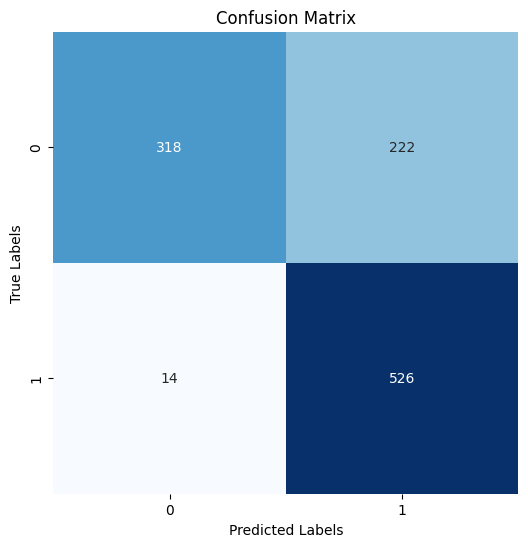

              precision    recall  f1-score   support

           0       0.96      0.59      0.73       540
           1       0.70      0.97      0.82       540

    accuracy                           0.78      1080
   macro avg       0.83      0.78      0.77      1080
weighted avg       0.83      0.78      0.77      1080



In [ ]:
conf_xgb_matrix = confusion_matrix(y_fin_test,y_fin_pred_test)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_xgb_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_fin_test,y_fin_pred_test))

In [ ]:
New_data = pd.read_csv('/content/drive/MyDrive/Angle_Open_landmarks_finetune_norm.csv')

In [ ]:
X_new = New_data.drop('Class', axis=1)
y_new = New_data['Class']
X_combined = pd.concat([X, X_new[50:]])
y_combined = pd.concat([Y, y_new[50:]])

In [ ]:
X_new

,Landmark_1_x,Landmark_2_x,Landmark_3_x,Landmark_4_x,Landmark_1_y,Landmark_2_y,Landmark_3_y,Landmark_4_y,Landmark_1_z,Landmark_2_z,Landmark_3_z,Landmark_4_z
0,0,0.500000,1.481132,0.481132,0,-0.566038,-0.251572,0.465409,0,-0.281200,-0.603560,-0.916226
1,0,0.410526,1.505263,0.505263,0,-0.743860,-0.547368,0.378947,0,-0.062136,-0.553738,-1.274640
2,0,0.444444,1.566667,0.566667,0,-0.918519,-0.637037,0.311111,0,-0.068529,-0.715724,-1.514965
3,0,0.465116,1.627907,0.627907,0,-1.038760,-0.744186,0.124031,0,0.017060,-0.634376,-1.660581
4,0,0.447917,1.552083,0.552083,0,-1.013889,-0.680556,0.111111,0,-0.028690,-0.646664,-1.478968
...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,0.415385,0.869231,-0.130769,0,-0.348718,-0.748718,-0.400000,0,0.007609,-0.565918,-0.789924
196,0,0.415385,0.876923,-0.123077,0,-0.338462,-0.748718,-0.420513,0,0.009583,-0.558754,-0.775416
197,0,0.430769,0.884615,-0.115385,0,-0.328205,-0.728205,-0.420513,0,-0.010685,-0.620646,-0.797771
198,0,0.430769,0.884615,-0.115385,0,-0.317949,-0.748718,-0.441026,0,-0.002905,-0.622820,-0.805450


In [ ]:
model_RF_fin = RandomForestClassifier(max_depth=10,n_estimators=300,min_samples_split=0.001,min_samples_leaf=0.001,max_features='log2',criterion='entropy')
model_RF_fin.fit(X_combined, y_combined)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       min_samples_leaf=0.001, min_samples_split=0.001,
                       n_estimators=300)

In [ ]:
y_fin_pred_test = model_RF_fin.predict(X_fin_test)

In [ ]:
y_fin_pred_test[900:990]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

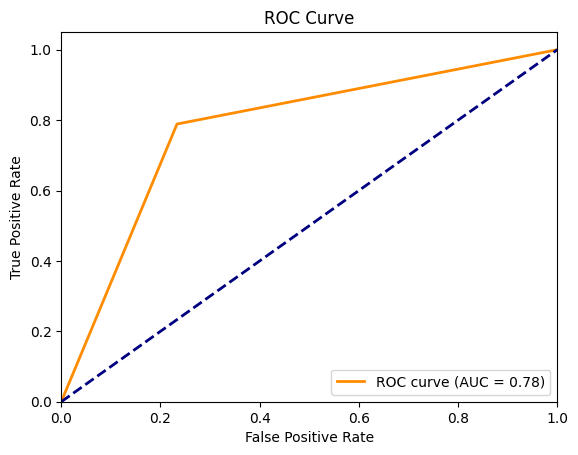

In [ ]:
fpr, tpr, thresholds = roc_curve(y_fin_test,y_fin_pred_test)
auc_xg_score = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_xg_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

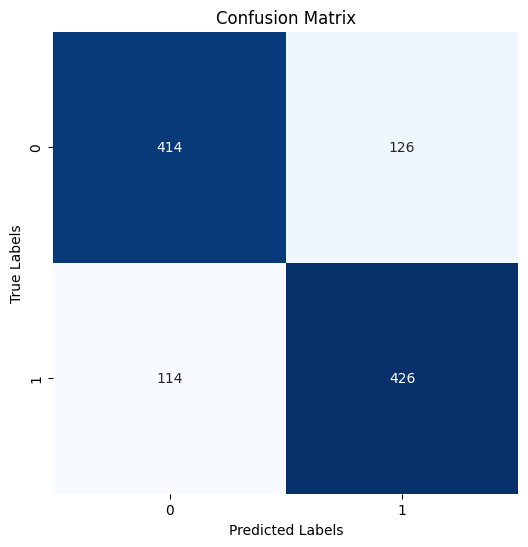

              precision    recall  f1-score   support

           0       0.78      0.77      0.78       540
           1       0.77      0.79      0.78       540

    accuracy                           0.78      1080
   macro avg       0.78      0.78      0.78      1080
weighted avg       0.78      0.78      0.78      1080



In [ ]:
conf_xgb_matrix = confusion_matrix(y_fin_test,y_fin_pred_test)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_xgb_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_fin_test,y_fin_pred_test))

In [ ]:
import joblib

joblib.dump(model_RF_fin, "ang_open_random_forest_model_up_2.pkl",compress=True)


['ang_open_random_forest_model_up_2.pkl']

In [ ]:
print(joblib.__version__)

1.4.2
